In [7]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, floor, percent_rank, when
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql.window import Window



In [8]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("MySparkApp") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.executor.cores", "4") \
    .config("spark.num.executors", "2") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

# Load the dataset
rplace_df = spark.read.parquet('../2022_rplace.parquet')

# Group by user_id_int and count pixels
user_pixel_counts_df = rplace_df.groupBy("user_id_int").agg(count("*").alias("total_pixels_by_user"))

# Create a window spec for percentile rank
window_spec = Window.orderBy("total_pixels_by_user")

# Add percentile rank to the DataFrame
ranked_users_df = user_pixel_counts_df.withColumn(
    "percentile_rank", percent_rank().over(window_spec)
)

# Join with the original DataFrame and calculate XQuad, YQuad, and percentile group
final_df = rplace_df.join(ranked_users_df, "user_id_int", "inner").withColumn(
    "XQuad", floor(col("X") / 100)
).withColumn(
    "YQuad", floor(col("Y") / 100)
).withColumn(
    "percentile_group", 
    (col("percentile_rank") * 100).cast("int")
).withColumn(
    "percentile_category",
    when(col("percentile_rank") <= 0.25, 1)
    .when((col("percentile_rank") > 0.25) & (col("percentile_rank") <= 0.50), 2)
    .when((col("percentile_rank") > 0.50) & (col("percentile_rank") <= 0.75), 3)
    .otherwise(4) 
)

final_df.show()

+-----------+--------------------+-------------------+----+----+--------------------+------------------+-----+-----+----------------+-------------------+
|user_id_int|           timestamp|pixel_color_english|   x|   y|total_pixels_by_user|   percentile_rank|XQuad|YQuad|percentile_group|percentile_category|
+-----------+--------------------+-------------------+----+----+--------------------+------------------+-----+-----+----------------+-------------------+
|         26|2022-04-04 01:00:...|      darkturquoise|1422|1689|                 105|0.9802573762831318|   14|   16|              98|                  4|
|         26|2022-04-04 01:39:...|              black|1413|1629|                 105|0.9802573762831318|   14|   16|              98|                  4|
|         26|2022-04-04 01:34:...|        darkmagenta| 500|1325|                 105|0.9802573762831318|    5|   13|              98|                  4|
|         26|2022-04-04 01:26:...|           deeppink| 556|1316|            

+------------------+-------------------------+
|   percentile_rank|avg(total_pixels_by_user)|
+------------------+-------------------------+
|0.9495884027413937|                     64.0|
|0.9995495679040353|                    350.0|
|0.9740370593103284|                     92.0|
|0.9993626906016033|                    325.0|
|0.6748495806290309|                     12.0|
|0.9922031706913198|                    155.0|
|               0.0|                      1.0|
|0.9925853058762412|                    158.0|
|0.9944000386084654|                    175.0|
| 0.999706198055455|                    379.0|
|0.9974990229881238|                    228.0|
|0.9998831535217269|                    440.0|
|0.9948202235534179|                    180.0|
|0.9980939478437009|                    247.0|
|0.9577741102304438|                     71.0|
|0.9728681128850648|                     90.0|
|0.9991902625751327|                    309.0|
| 0.999749642211845|                    390.0|
|0.8393867611

C:\Users\Andrew\AppData\Local\Temp\ipykernel_34960\856153952.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=percentile_rank_values, y=avg_pixels_values, palette='Blues_d')


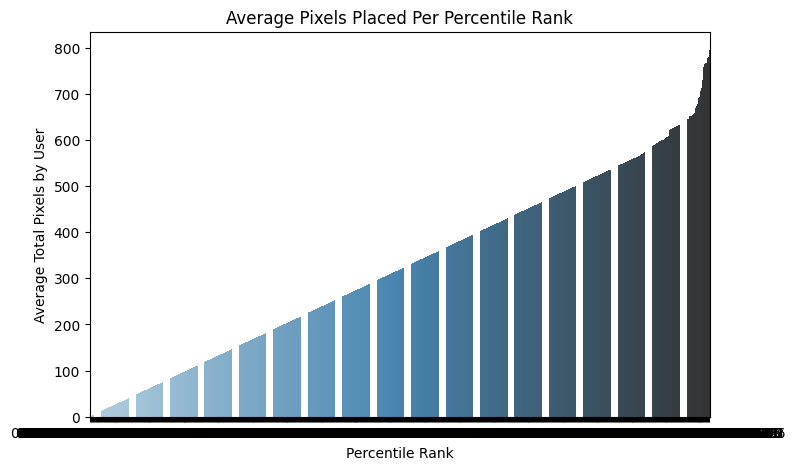

In [ ]:
# Drop duplicates based on user_id_int
deduped_df = final_df.dropDuplicates(["user_id_int"])

# Group by percentile rank and calculate the average total pixels
avg_pixels_by_percentile_df = deduped_df.groupBy("percentile_rank").agg(
    {"total_pixels_by_user": "avg"}
)

# Show the results
avg_pixels_by_percentile_df.show()

# Restart Spark and clear cache
spark.catalog.clearCache()

avg_pixels_by_percentile_df = avg_pixels_by_percentile_df.withColumnRenamed("avg(total_pixels_by_user)", "avg_pixels")
avg_pixels_by_percentile_data = avg_pixels_by_percentile_df.collect()

percentile_rank_values = [row['percentile_rank'] for row in avg_pixels_by_percentile_data]
avg_pixels_values = [row['avg_pixels'] for row in avg_pixels_by_percentile_data]

plt.figure(figsize=(8, 5))
sns.barplot(x=percentile_rank_values, y=avg_pixels_values, palette='Blues_d')

plt.xlabel("Percentile Rank")
plt.ylabel("Average Total Pixels by User")
plt.title("Average Pixels Placed Per Percentile Rank")
plt.show()

# Restart Spark and clear cache
spark.catalog.clearCache()

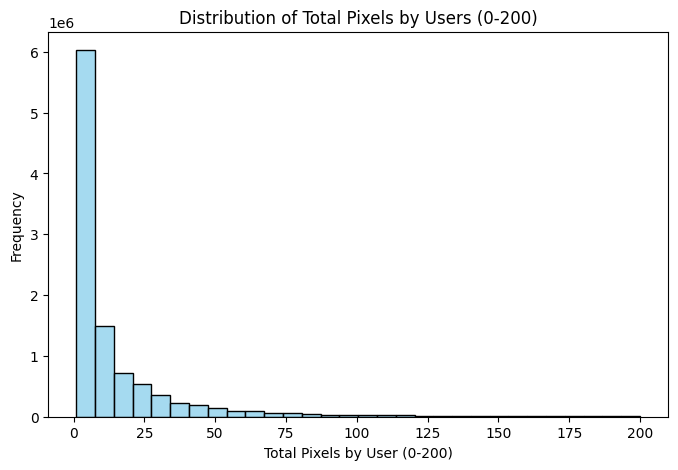

In [7]:
# Filter the users with total pixels <= 200 and plot distribution
filtered_df = deduped_df.filter(col('total_pixels_by_user') <= 200)

filtered_data = filtered_df.select('total_pixels_by_user').toPandas()['total_pixels_by_user'].tolist()

plt.figure(figsize=(8, 5))
sns.histplot(filtered_data, kde=False, color='skyblue', bins=30)

plt.xlabel("Total Pixels by User (0-200)")
plt.ylabel("Frequency")
plt.title("Distribution of Total Pixels by Users (0-200)")
plt.show()

# Restart Spark and clear cache
spark.catalog.clearCache()

In [ ]:
# Show group counts
group_counts_df = deduped_df.groupBy('percentile_group').agg(
    count("*").alias("count")
)

group_counts_df.show()

# Group by percentile group and calculate average pixels placed by user
avg_pixels_by_group_df = deduped_df.groupBy('percentile_group').agg(
    {"total_pixels_by_user": "avg"}
)

# Collect the results
avg_pixels_by_group_data = avg_pixels_by_group_df.collect()

print("Average Pixels Placed by User in Each Percentile Group:")
for row in avg_pixels_by_group_data:
    print(f"Percentile Group {row['percentile_group']}: Avg Pixels = {row['avg(total_pixels_by_user)']}")

+----------------+-------+
|percentile_group|  count|
+----------------+-------+
|              85| 111838|
|              65| 204489|
|              78|  99301|
|              81| 158661|
|              76| 114277|
|              91| 105278|
|              22|1175052|
|              93| 112086|
|              86| 100915|
|              94| 104374|
|              54| 330170|
|              96|  99450|
|              92|  89771|
|              41| 572021|
|              88| 120676|
|              72| 143961|
|              84|  61020|
|              87|  90755|
|              51| 383663|
|              69| 169180|
+----------------+-------+
only showing top 20 rows



ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "c:\Users\Andrew\Documents\CSC369\.venv\Lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "c:\Users\Andrew\Documents\CSC369\.venv\Lib\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ~~~~~~~~~~~~~~~~~~~~^^
  File "C:\Users\Andrew\AppData\Local\Programs\Python\Python313\Lib\socket.py", line 719, in readinto
    return self._sock.recv_into(b)
           ~~~~~~~~~~~~~~~~~~~~^^^
KeyboardInterrupt


KeyboardInterrupt: 

+-----------+--------------------+-------------------+----+----+--------------------+-------------------+-----+-----+----------------+-------------------+
|user_id_int|           timestamp|pixel_color_english|   x|   y|total_pixels_by_user|    percentile_rank|XQuad|YQuad|percentile_group|percentile_category|
+-----------+--------------------+-------------------+----+----+--------------------+-------------------+-----+-----+----------------+-------------------+
|       2173|2022-04-04 01:21:...|               plum|  85|1871|                   2|0.22545484634977092|    0|   18|              22|                  1|
|       2173|2022-04-04 00:39:...|              black|1940| 119|                   2|0.22545484634977092|   19|    1|              22|                  1|
|       2214|2022-04-04 01:30:...|           darkcyan|1800|1844|                   2|0.22545484634977092|   18|   18|              22|                  1|
|       2214|2022-04-04 21:27:...|            crimson| 151|1365|      

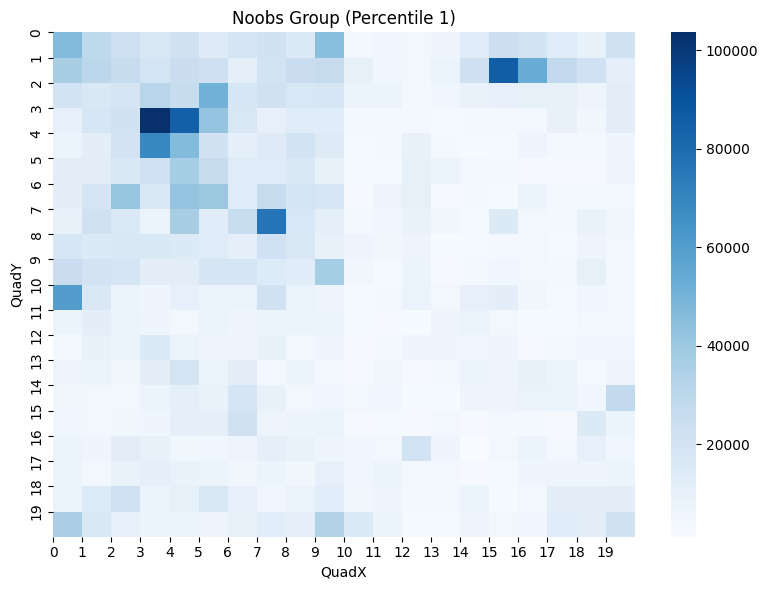

+-----------+--------------------+-------------------+----+----+--------------------+------------------+-----+-----+----------------+-------------------+
|user_id_int|           timestamp|pixel_color_english|   x|   y|total_pixels_by_user|   percentile_rank|XQuad|YQuad|percentile_group|percentile_category|
+-----------+--------------------+-------------------+----+----+--------------------+------------------+-----+-----+----------------+-------------------+
|       2040|2022-04-04 00:54:...|    mediumslateblue|1150|1902|                   4|0.4126584134328946|   11|   19|              41|                  2|
|       2040|2022-04-04 01:17:...|              black|1133|1902|                   4|0.4126584134328946|   11|   19|              41|                  2|
|       2040|2022-04-04 02:10:...|              black|1121|1904|                   4|0.4126584134328946|   11|   19|              41|                  2|
|       2040|2022-04-04 03:14:...|              black|1127|1902|            

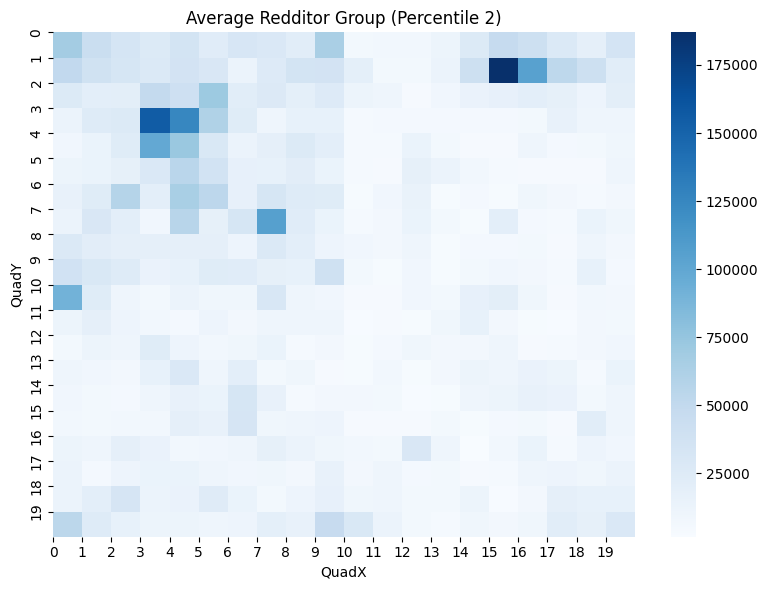

+-----------+--------------------+-------------------+----+----+--------------------+------------------+-----+-----+----------------+-------------------+
|user_id_int|           timestamp|pixel_color_english|   x|   y|total_pixels_by_user|   percentile_rank|XQuad|YQuad|percentile_group|percentile_category|
+-----------+--------------------+-------------------+----+----+--------------------+------------------+-----+-----+----------------+-------------------+
|        541|2022-04-04 01:09:...|    mediumslateblue|1208|1429|                  13|0.6927556050427203|   12|   14|              69|                  3|
|        541|2022-04-04 00:56:...|              black|1810|1931|                  13|0.6927556050427203|   18|   19|              69|                  3|
|        541|2022-04-04 19:18:...|              black|1826|1946|                  13|0.6927556050427203|   18|   19|              69|                  3|
|        541|2022-04-03 16:43:...|              black|1495| 640|            

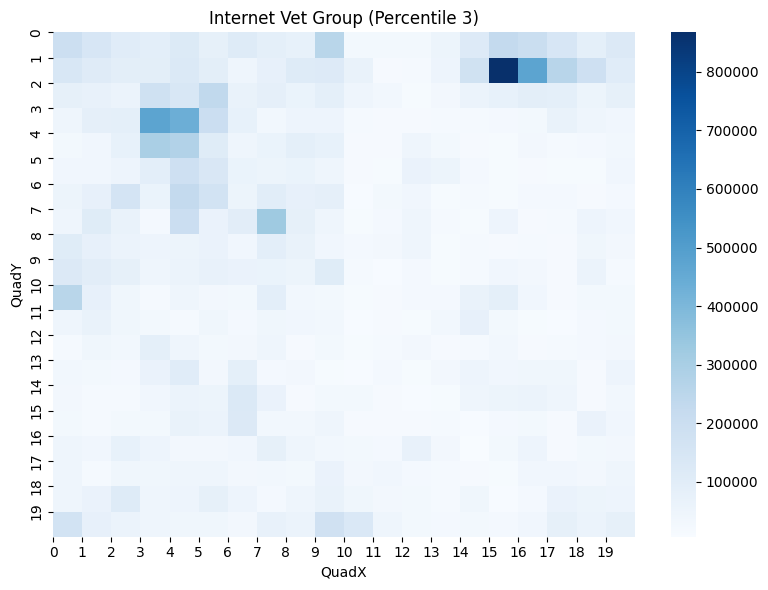

+-----------+--------------------+-------------------+----+----+--------------------+------------------+-----+-----+----------------+-------------------+
|user_id_int|           timestamp|pixel_color_english|   x|   y|total_pixels_by_user|   percentile_rank|XQuad|YQuad|percentile_group|percentile_category|
+-----------+--------------------+-------------------+----+----+--------------------+------------------+-----+-----+----------------+-------------------+
|         26|2022-04-04 01:00:...|      darkturquoise|1422|1689|                 105|0.9802573762831318|   14|   16|              98|                  4|
|         26|2022-04-04 01:39:...|              black|1413|1629|                 105|0.9802573762831318|   14|   16|              98|                  4|
|         26|2022-04-04 01:34:...|        darkmagenta| 500|1325|                 105|0.9802573762831318|    5|   13|              98|                  4|
|         26|2022-04-04 01:26:...|           deeppink| 556|1316|            

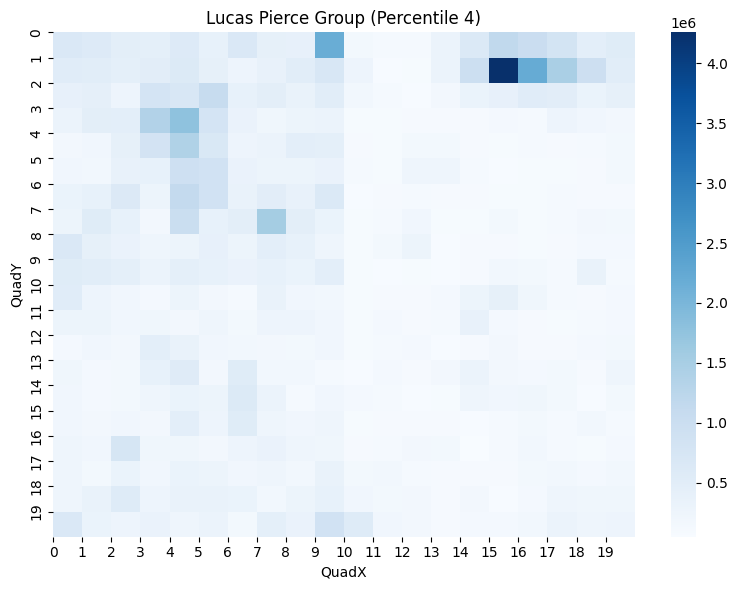

In [9]:
from pyspark.sql import functions as F

df_noob = final_df.filter(col("percentile_category") == 1)
df_gamer = final_df.filter(col("percentile_category") == 2)
df_internet_vet = final_df.filter(col("percentile_category") == 3)
df_lucas_pierce = final_df.filter(col("percentile_category") == 4)

def plot_heatmap(df, title):
    df.show(10)
    quadrant_counts_df = df.groupBy('XQuad', 'YQuad').agg(F.count('*').alias('total')).orderBy('total', ascending=False)
    
    quadrant_counts_df.show(10)

    quadrant_counts_data = quadrant_counts_df.collect()  

    top_5_quadrants = quadrant_counts_data[:5]
    print(f"Top 5 quadrant combinations for {title}:")
    print(f"{'XQuad':<5} {'YQuad':<5} {'Count':<10} {'Percentage':<10}")
    
    total_count = sum([row['total'] for row in quadrant_counts_data])

    for row in top_5_quadrants:
        x, y, count = row['XQuad'], row['YQuad'], row['total']
        percentage = (count / total_count) * 100
        print(f"{x:<5} {y:<5} {count:<10} {percentage:>6.2f}%")

    heatmap_data = np.zeros((20, 20), dtype=float)

    # Fill the heatmap data array with the counts
    for row in quadrant_counts_data:
        x, y, count = row['XQuad'], row['YQuad'], row['total']
        if x == 20: x = 19 
        if y == 20: y = 19
        heatmap_data[int(x), int(y)] = count

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=False, fmt='.0f', cmap='Blues', cbar=True)

    plt.title(title)
    plt.xlabel('QuadX')
    plt.ylabel('QuadY')

    plt.xticks(np.arange(20), labels=np.arange(0, 20))
    plt.yticks(np.arange(20), labels=np.arange(0, 20))

    plt.tight_layout()
    plt.show()

# Example usage:
plot_heatmap(df_noob, "Noobs Group (Percentile 1)")
plot_heatmap(df_gamer, "Average Redditor Group (Percentile 2)")
plot_heatmap(df_internet_vet, "Internet Vet Group (Percentile 3)")
plot_heatmap(df_lucas_pierce, "Lucas Pierce Group (Percentile 4)")